In [353]:
import json
from tqdm import tqdm
import random
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
from sklearn.manifold import TSNE

In [354]:
class NGramLanguageModeler(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(NGramLanguageModeler, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * embedding_dim, 4)
        self.linear2 = nn.Linear(4, vocab_size)

    def forward(self, inputs):
        # Encode context tokens
        embeds = self.embeddings(inputs)
            
        # Concat each context
        #embeds = torch.cat((embeds))
        model_input = embeds.view(inputs.size(0), -1)
        
        out = F.relu(self.linear1(model_input))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs
    

# Language Voc

### Pick one

In [355]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
vocabulary = ['<SOS>','Located', 'Object', 'Landmark', 'North', 'South', 'East', 'West', 'Center', 'Not', '<EOS>']
word_to_ix = {word : i for i, word in enumerate(vocabulary)}

print(word_to_ix)

{'<SOS>': 0, 'Located': 1, 'Object': 2, 'Landmark': 3, 'North': 4, 'South': 5, 'East': 6, 'West': 7, 'Center': 8, 'Not': 9, '<EOS>': 10}


In [53]:
CONTEXT_SIZE = 2
EMBEDDING_DIM = 10
vocabulary = ['<SOS>', 'Located', 'Object', 'Landmark', 'I', 'You', 'North', 'South', 'East', 'West', 'Center', 'Not', 'Push', 'Search', '<EOS>']
word_to_ix = {word : i for i, word in enumerate(vocabulary)}

print(word_to_ix)

{'<SOS>': 0, 'Located': 1, 'Object': 2, 'Landmark': 3, 'I': 4, 'You': 5, 'North': 6, 'South': 7, 'East': 8, 'West': 9, 'Center': 10, 'Not': 11, 'Push': 12, 'Search': 13, '<EOS>': 14}


# Load Data

In [356]:
def load():
    # Sentences
    sentences = []
    # Open file
    with open("../data/Sentences_Generated_P1.json", 'r') as f:
        data = json.load(f)
    # Get the sentence of both agent for each step
    for step in range(len(data) -1 ) :
        sentences.append(data["Step " + str(step)]["Agent_0"]["Sentence"])
        sentences.append(data["Step " + str(step)]["Agent_1"]["Sentence"])
    
    """if sentences[0][0] == '<SOS>':
        for sentence in sentences:
            # We delete first and last character
            sentence.pop(0)
            sentence.pop()"""
    return sentences

data = load()

print(data[0])

['<SOS>', 'Located', 'East', 'Landmark', 'South', 'West', '<EOS>']


### Transform the Data

##### Context order left to right

In [357]:
ngrams = []
for sentence in data:
    ngram = [
    (
        [word_to_ix[sentence[i - j]] for j in range(CONTEXT_SIZE,0,-1)],
        word_to_ix[sentence[i]]
    )
    for i in range(CONTEXT_SIZE, len(sentence))
    ]
    for ni in ngram:
        ngrams.append(ni)    
        
print(data[0])
print(ngrams[:5])

['<SOS>', 'Located', 'East', 'Landmark', 'South', 'West', '<EOS>']
[([0, 1], 6), ([1, 6], 3), ([6, 3], 5), ([3, 5], 7), ([5, 7], 10)]


##### Context order right to left

In [347]:
ngrams = []
for sentence in data:
    ngram = [
    (
        [word_to_ix[sentence[i - j - 1]] for j in range(CONTEXT_SIZE)],
        word_to_ix[sentence[i]]
    )
    for i in range(CONTEXT_SIZE, len(sentence))
    ]
    for ni in ngram:
        ngrams.append(ni)    

print(data[0])
print(ngrams[:5])

[([1, 0], 6), ([6, 1], 3), ([3, 6], 5), ([5, 3], 7), ([7, 5], 10)]


## Split the Data

In [358]:
# Keep 20% of the data for the training
split = len(ngrams)//100*20

train_data = ngrams[:split]
test_data = ngrams[split:]

print(len(train_data))
print(len(test_data))

69860
279454


# Model

In [359]:
losses = []
loss_function = nn.NLLLoss()
model = NGramLanguageModeler(len(vocabulary), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.1)
total_loss = 0
nb_epoch = 3000

# Training

In [360]:
# To keep track of the loss
losses = []
losses_test = []

for epoch in tqdm(range(nb_epoch)):
    # Create the batch
    batch = random.sample(train_data,64)

    # Zero out the gradients 
    model.zero_grad()
    
    #Init the loss
    loss = 0
    
    context_batch = []
    target_batch = []
    
    # Get the list of context and target
    for context, target in batch:
        context_batch.append(context)
        # Get the id of the target word
        #target_batch.append(word_to_ix[target])
        target_batch.append(target)
        
    # Tranform in into a Tensor
    target_batch = torch.tensor(target_batch, dtype=torch.long)
    
    # Adapt the shape of the context
    """context_idxs = []
    for w in context_batch:
        context_id = []
        for word in w:
            context_id.append(word_to_ix[word])
        context_idxs.append(context_id)"""

    # Transform the context into a tensor
    context_idxs = torch.tensor(context_batch, dtype=torch.long)
    
    # Forward pass
    log_probs = model(context_idxs)
    
    # En moyenne 2.3 quand pas de backward
    loss = loss_function(log_probs, target_batch)
    
    losses.append(loss.item())
    
    loss.backward()
    
    optimizer.step()
    
    # Every 10000
    if epoch % 100 == 0:
        with torch.no_grad():
            context_batch_test = []
            target_batch_test = []
            # Create the batch
            batch_test = random.sample(test_data,64)

            # Get the list of context and target
            for context, target in batch_test:
                context_batch_test.append(context)
                # Get the id of the target word
                #target_batch_test.append(word_to_ix[target])
                target_batch_test.append(target)
                
            # Tranform in into a Tensor
            target_batch_test = torch.tensor(target_batch_test, dtype=torch.long)

            # Adapt the shape of the context
            """context_idxs_test = []
            for w in context_batch_test:
                context_id = []
                for word in w:
                    context_id.append(word_to_ix[word])
                context_idxs_test.append(context_id)"""

            # Transform the context into a tensor
            context_idxs_test = torch.tensor(context_batch_test, dtype=torch.long)

            # Forward pass
            log_probs_test = model(context_idxs_test)

            # En moyenne 2.3 quand pas de backward
            loss_test = loss_function(log_probs_test, target_batch_test)

            losses_test.append(loss_test)
        
        



100%|████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:02<00:00, 1222.55it/s]


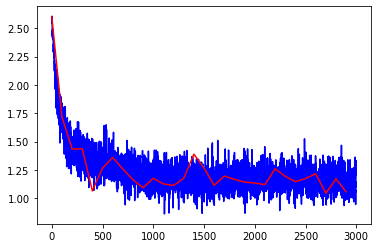

In [361]:
# Representation with matplotlib
y = np.array(losses)
plt.plot(y, color='blue')
test = np.array(losses_test)
plt.plot(np.arange(nb_epoch//100) * 100, test, color='red')
plt.show()

# Representation of the embedding

### Using TSNE

In [341]:
embeddings = model.embeddings.weight.cpu().detach().numpy()
data_frame = pd.DataFrame(embeddings)
tsne = TSNE(n_components=2,perplexity=2,
            learning_rate="auto")

embed_df = tsne.fit_transform(data_frame.values)
embed_df = pd.DataFrame(embed_df, columns=list('XY'))
embed_df["Words"] = vocabulary


# Create the fig
fig = px.scatter(embed_df, x='X', y='Y', text='Words', log_x = False, size_max = 60)

fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(
    height=600,
    title_text='Word embedding chart'
)
# displaying the figure
fig.write_html("../n-gram_tsne.html")
fig

C:\Users\tara0\Desktop\MPEObservationParser\venv\lib\site-packages\sklearn\manifold\_t_sne.py:795: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.



### Using PCA

In [342]:
from sklearn.decomposition import PCA

embeddings = model.embeddings.weight.cpu().detach().numpy()
data_frame = pd.DataFrame(embeddings)
pca = PCA(n_components=2)
embed_df = pca.fit_transform(data_frame.values)
print(embed_df)

embed_df = pd.DataFrame(embed_df, columns=list('XY'))
embed_df["Words"] = vocabulary

# Create the fig
fig = px.scatter(embed_df, x='X', y='Y', text='Words', log_x = False, size_max = 60)

fig.update_traces(textposition='top center')
# setting up the height and title
fig.update_layout(
    height=600,
    title_text='Word embedding chart'
)



# displaying the figure
fig.write_html("../n-gram_pca.html")
fig

[[ 2.6964672  -0.44566515]
 [ 0.46547547  3.1284373 ]
 [-2.6810365   0.9246961 ]
 [-1.6538465   0.4821334 ]
 [-2.4798856   0.52000976]
 [ 0.9987718   1.7668307 ]
 [ 1.555649   -0.959947  ]
 [ 1.8299822  -0.29100925]
 [-2.105844   -2.820735  ]
 [-0.2039056  -1.2738488 ]
 [ 1.5781729  -1.0309025 ]]


In [64]:
embed_df

,X,Y,Words
0,-1.758856,1.722297,<SOS>
1,0.446905,-1.706969,Located
2,0.223857,0.718557,Object
3,1.722282,-0.741905,Landmark
4,1.665162,-0.168273,I
5,0.912749,2.478273,You
6,-0.770061,1.643901,North
7,-2.058128,1.002399,South
8,-2.622594,-1.357042,East
9,-1.708819,-1.936257,West


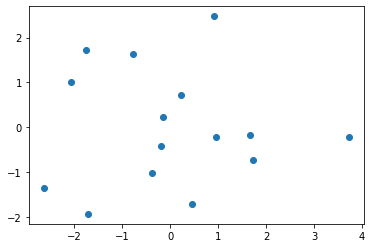

In [65]:
plt.scatter(embed_df["X"], embed_df["Y"])

### Calculate the distance between the words

In [46]:
import math

dist = []

for a in range(len(model.embeddings.weight)):
    dist_point = []
    for b in range(len(model.embeddings.weight)):
        if a != b:
            distance = 0
            for i in range(10):
                distance += (model.embeddings.weight[a][i].item() - model.embeddings.weight[b][i]) \
                    * (model.embeddings.weight[a][i] - model.embeddings.weight[b][i])
            distance = math.sqrt(distance)
            dist_point.append(round(distance,2))
        else :
            dist_point.append(0)
    dist.append(dist_point)
    
for d in dist:
    print(d)


[0, 4.45, 4.31, 6.22, 3.2, 2.62, 4.53, 3.6, 3.4, 4.95, 4.65]
[4.45, 0, 4.74, 5.45, 3.18, 3.47, 3.75, 4.32, 4.34, 4.67, 3.48]
[4.31, 4.74, 0, 5.3, 3.71, 4.4, 4.63, 5.34, 3.62, 3.6, 3.35]
[6.22, 5.45, 5.3, 0, 6.0, 5.48, 4.53, 4.89, 5.1, 5.58, 4.93]
[3.2, 3.18, 3.71, 6.0, 0, 3.18, 4.36, 4.36, 3.78, 4.31, 4.51]
[2.62, 3.47, 4.4, 5.48, 3.18, 0, 3.38, 3.17, 4.02, 4.72, 3.69]
[4.53, 3.75, 4.63, 4.53, 4.36, 3.38, 0, 2.97, 3.85, 4.35, 3.58]
[3.6, 4.32, 5.34, 4.89, 4.36, 3.17, 2.97, 0, 3.26, 5.28, 4.66]
[3.4, 4.34, 3.62, 5.1, 3.78, 4.02, 3.85, 3.26, 0, 3.04, 4.03]
[4.95, 4.67, 3.6, 5.58, 4.31, 4.72, 4.35, 5.28, 3.04, 0, 3.5]
[4.65, 3.48, 3.35, 4.93, 4.51, 3.69, 3.58, 4.66, 4.03, 3.5, 0]


In [47]:
#TESTING
contexte = [(['South', 'Located'], 'West')]

context_batch = []
target_batch = []

# Get the list of context and target
for context, target in contexte:
    context_batch.append(context)
    # Get the id of the target word
    target_batch.append(word_to_ix[target])

# Tranform in into a Tensor
target_batch = torch.tensor(target_batch, dtype=torch.long)

# Adapt the shape of the context
context_idxs = []
for w in context_batch:
    context_id = []
    for word in w:
        context_id.append(word_to_ix[word])
    context_idxs.append(context_id)

# Transform the context into a tensor
context_idxs = torch.tensor(context_idxs, dtype=torch.long)

# Forward pass
log_probs = model(context_idxs)

print(log_probs)
    
#Print result
print(f'Context: {contexte}\n')
print(f'Prediction: {torch.argmax(log_probs[0]).item()}')

tensor([[-7.3338, -7.7926, -5.6520, -5.4559, -1.7841, -1.7994, -1.4732, -1.0852,
         -2.5342, -7.0786, -4.5452]], grad_fn=<LogSoftmaxBackward0>)
Context: [(['South', 'Located'], 'West')]

Prediction: 7
